In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv("../datasets/old_faithful.dat", delim_whitespace=True,
                 skiprows=25)

In [3]:
df.head()

,eruptions,waiting
1,3.600,79
2,1.800,54
3,3.333,74
4,2.283,62
5,4.533,85


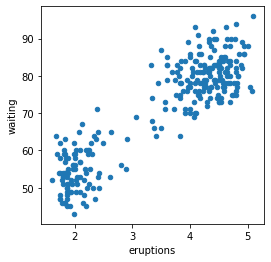

In [4]:
fig, ax = plt.subplots(figsize=plt.figaspect(1.0))
df.plot.scatter(x="eruptions", y="waiting", ax=ax)

In [5]:
# standardize the data to make GMM initializations easier
df_scaled = df.eval("eruptions = (eruptions - eruptions.mean()) / eruptions.std()")
df_scaled = df_scaled.eval("waiting = (waiting - waiting.mean()) / waiting.std()")

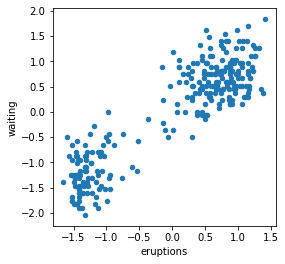

In [6]:
fig, ax = plt.subplots(figsize=plt.figaspect(1.0))
df_scaled.plot.scatter(x="eruptions", y="waiting", ax=ax)

In [7]:
from scipy.stats import multivariate_normal as mvn

class GMM:
    def __init__(self, n_mixtures: int):
        # Note that labels are latent variables in a GMM        
        self.n_mixtures = n_mixtures
        
    def _initialize(self, X):
        assert X.ndim == 2
        self.n_dim = X.shape[1]
        self.latent_prior = np.ones(self.n_mixtures) / self.n_mixtures
        # Each mixture i is N(mu_i, sigma_i^2 I)
        self.means = np.random.randn(self.n_mixtures, self.n_dim)
        self.covs = np.tile(np.eye(self.n_dim), (self.n_mixtures, 1, 1))
    
    def fit(self, X: np.ndarray, max_iters: int):
        self._initialize(X)
        for i in range(max_iters):
            # E-step
            joint_likelihoods = self.joint_likelihoods(X)
            observation_likelihoods = self.observation_likelihoods(X, joint_likelihoods)
            posteriors = joint_likelihoods / observation_likelihoods[:, None]
            
            # M-step
            normalization = posteriors.sum(axis=0)
            means = ((posteriors[:, None, :] * X[:, :, None]).sum(axis=0) / normalization)
            centered = X[:, :, None] - means[None, :, :]
            covs = (centered * posteriors[:, None, :]).transpose(2, 1, 0) @ centered.transpose(2, 0, 1)

            self.covs = covs / normalization[:, None, None]
            self.means = means.swapaxes(0, 1)
            self.latent_prior = normalization / len(X)
            
            print(f"Observation Log Likelihood: {np.log(observation_likelihoods).sum(0)}")
        
    def joint_likelihoods(self, X):
        conditional_likelihoods = np.stack([mvn.pdf(X, mean=mean, cov=cov)
                                            for mean, cov in zip(self.means, self.covs)],
                                           axis=1)
        return self.latent_prior * conditional_likelihoods
    
    def observation_likelihoods(self, X, joint_likelihoods=None):
        if joint_likelihoods is None:
            joint_likelihoods = self.joint_likelihoods(X)
        return joint_likelihoods.sum(axis=1)
    
    def predict(self, X):
        pass
    
    def sample(self, n_samples):
        labels = np.random.choice(self.n_mixtures, n_samples, p=self.latent_prior)
        # TODO: Speed this up since scipy doesn't have batched distributions
        samples = np.stack([mvn.rvs(mean=self.means[i], cov=self.covs[i], size=1) for i in labels], axis=0)
        return samples
        

In [8]:
model = GMM(2)
model.fit(df_scaled.values, 20)

Observation Log Likelihood: -882.652615998523
Observation Log Likelihood: -531.9863394698042
Observation Log Likelihood: -519.3806059717265
Observation Log Likelihood: -482.955110835215
Observation Log Likelihood: -406.27537079310395
Observation Log Likelihood: -384.6019026380022
Observation Log Likelihood: -384.4631251073362
Observation Log Likelihood: -384.4590849178775
Observation Log Likelihood: -384.45886613073884
Observation Log Likelihood: -384.4588536421674
Observation Log Likelihood: -384.45885292089093
Observation Log Likelihood: -384.45885287911665
Observation Log Likelihood: -384.4588528766957
Observation Log Likelihood: -384.45885287655534
Observation Log Likelihood: -384.4588528765472
Observation Log Likelihood: -384.4588528765468
Observation Log Likelihood: -384.4588528765468
Observation Log Likelihood: -384.45885287654676
Observation Log Likelihood: -384.4588528765468
Observation Log Likelihood: -384.45885287654664


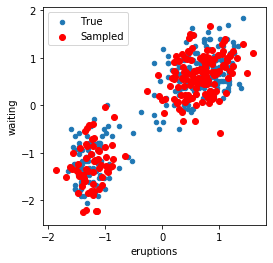

In [9]:
X_sampled = model.sample(200)
fig, ax = plt.subplots(figsize=plt.figaspect(1.0))
df_scaled.plot.scatter(x="eruptions", y="waiting", ax=ax, label="True")
ax.scatter(*X_sampled.T, c='r', label="Sampled")

ax.legend()

[Text(0, 0.5, 'waiting'), Text(0.5, 0, 'eruptions')]

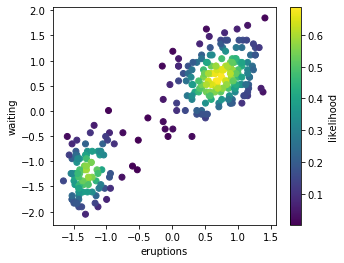

In [10]:
X_likelihoods = model.observation_likelihoods(df_scaled.values)
fig, ax = plt.subplots(figsize=plt.figaspect(0.8))
mappable = ax.scatter(x="eruptions", y="waiting", data=df_scaled, c=X_likelihoods)
cbar = fig.colorbar(mappable)
cbar.ax.set_ylabel("likelihood")
ax.set(xlabel="eruptions", ylabel="waiting")